# Regularised linear regression and gradient descent from scratch with numpy

The focus of this notebook is the mathematics of linear regression, how to regularise it to prevent overfitting, and how to implement it using numpy. For ridge regression there exists a simple analytic solution, however for Lasso or elastic net regularisation I implement my own gradient descent algorithm from first principles to find the optimal solution.

In [125]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

diabetes_data = datasets.load_diabetes()
df_diabetes = pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)
df_diabetes['target'] = pd.Series(diabetes_data.target)
X, y = datasets.load_diabetes(return_X_y=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [89]:
print(df_diabetes.info())
# I am using a dataset which requires no preprocessing so that i can focus on implementing the algorithm.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
age       442 non-null float64
sex       442 non-null float64
bmi       442 non-null float64
bp        442 non-null float64
s1        442 non-null float64
s2        442 non-null float64
s3        442 non-null float64
s4        442 non-null float64
s5        442 non-null float64
s6        442 non-null float64
target    442 non-null float64
dtypes: float64(11)
memory usage: 38.1 KB
None


I have data describing medical characteristics of each observation, including: age, sex, bmi (body mass index), bp (blood pressure) and 6 blood serum measurements. The aim is to find some **linear** superposition of these features that predicts the progression of diabetes relative to its baseline measurement.

So we can start a relationship between the dependent and independent variables as such:


$$y_i = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \theta_{3}x_{3} + \cdots + \varepsilon_{i} $$

Where $y_i$ is the dependent (target) variable, $x_k$ are the features, the $\theta$'s are the parameters of model and $\varepsilon_i$ is the error (difference between predicted value and true value).

From now on I'll use suffix notation along with Einstein's summation convention. This means that, for matrix-vector and matrix-matrix multiplication $\textbf{c}=\textbf{A}\textbf{b}$ and $\textbf{C} = \textbf{A}\textbf{B}$ are instead written as $c_i = A_{ij}b_{j}$ and $C_{ik} = A_{ij}B_{jk}$. The rules are that repeated indices are summed over and you cannot have an in any term you cannot have the same indices appearing more than twice. I prefer to use this notation as it is more robust than the standard linear algebra vector / matrix notation. The equivalent of the identity of the identity matrix is the Kronecker delta: $\delta_{ij}$, and it causes the contraction of indices in the following way: $X_{ij}\delta_{jk}=X_{ik}$.

We can re-write the previous assumption as 

$$y_i = X_{ij}\theta_{j}+\varepsilon_{i} $$

where $X_{ij}$ refers to the N x (M+1) feature matrix. N refers to the number of observations and M refers to the number of features (dependent variables), $X_{ij}$ has M+1 rows since a column of ones has been added to facilitate the inclusion of the constant 'bias' term $\theta_0$.

We can then find the optimal parameters $\theta_{j}$ by minimising the mean square error, $MSE(\theta) = \frac{1}{N}|\boldsymbol{\varepsilon}|^2 $ with respect the parameters $\theta_{j}$.

$$\frac{1}{N}|\boldsymbol{\varepsilon}|^2 =\frac{1}{N}\varepsilon_{i}\varepsilon_{i} = \frac{1}{N}(y_i-X_{ip}\theta_{p})((y_i-X_{ik}\theta_{k}))$$

$$\frac{\partial|\boldsymbol{\varepsilon}|^2}{\partial\theta_{j}} = \frac{1}{N}\frac{\partial}{\partial\theta_{j}}(y_i-X_{ip}\theta_{p})((y_i-X_{ik}\theta_{k})) = 0$$

$$ -X_{ip}\delta_{pj}(y_i-X_{ik}\theta_{k})-X_{ik}\delta_{jk}(y_i-X_{ip}\theta_p)=0$$

$$ -X_{ij}y_{i}+X_{ij}X_{ik}\theta_{k}-X_{ij}y_i+X_{ij}X_{ik}\theta_{k}=0$$

$$ X_{ij}X_{ik}\theta_{k}=X_{ij}y_i$$

$$ \theta_k = (X_{pj}X_{pk})^{-1}X_{ij}y_{i}$$

Or in standard linear algebra notation:
$$\boldsymbol{\theta}=(\textbf{X}^{T}\textbf{X})^{-1}\textbf{X}^{T}\textbf{y}$$

If you're particularly concerned about computational efficiency then it would be a good idea to perform a Singular Value Decomposition (SVD) which entails 'factorising' the feature matrix $\textbf{X}$ into a product of two unitary matrices $(\textbf{U}, \textbf{V})$ and one diagonal matrix $\bf{\Sigma}$ such that $\textbf{X}$ can be written as $\textbf{X} = \bf{ U \Sigma V^{T}}$. It's essentially the generalistion of an eigendecomposition to non-square metrices and allows us to write $\bf \theta$ as $\boldsymbol{\theta} = \textbf{V} \boldsymbol{\Sigma}^{-1} \textbf{U}^{T} \textbf{y} $. However, for our purposes there's no need to do this as computing the original equation for $\boldsymbol{\theta}$ isn't particularly computationally expensive.

As with any machine learning model there is a trade off between model complexity (performance) and interpretability. Linear Regression lies at one extreme of this trade off, having very low complexity and very high interpretability. We interpret the model weights as: for a unit increase in an independent variable, $x_k$, the increase in the target variable is $\theta_k$.

## Regularisation

So we found a simple analytical solution for the model parameters $\theta_i$ which minimise the mean square error. A ubiquitous problem in creating machine learning models is that of overfitting to the training data, whilst this is less prevalent in simple models such as this one can still be worth constraining your models to prevent this occuring. We can do this by including a regularisation term - $R(\theta)$ in the function we choose to minimise. Enter the cost function:

$$J(\theta) = MSE(\theta) + R(\theta)$$

Rather than simply minimising the mean square error, if we choose to minimise a linear combination of this and some other function of the $\theta$'s which places some constraints the model.

One such regularisation we can consider is **Ridge** regularisation, which is simply just the sum of the squares of the model parameters:

$$R(\theta) = \frac{\alpha}{2}\sum_{i=1}^{N}{\theta_i}^2$$

Another type of regularisation is **Lasso** regularisation, which is just the sum of the absolute model parameter values:

$$R(\theta) = \alpha \sum_{i=1}^{N}{|\theta_i|} $$

Intuitively, they both introduce a trade off between a how well the model fits and how complicated the model is (how large the model parameters become). The parameter $\lambda$ controls how much you want to regularise the model, so $\lambda = 0$ would correspond to plain linear regression. We can delve further into how Ridge and Lasso regularisation differ by plotting them.

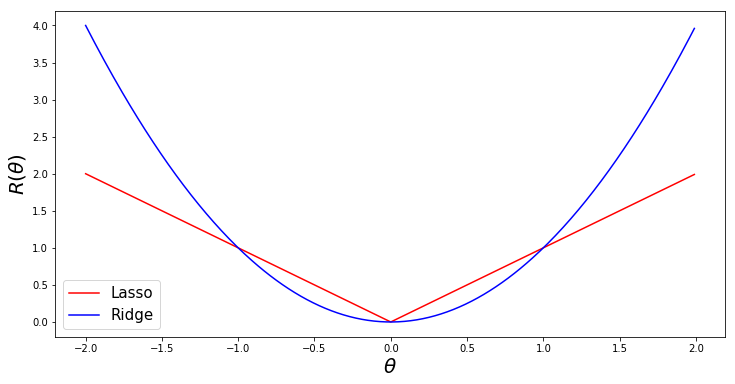

In [138]:
R1 = []
R2 = []
theta = np.arange(-2,2,0.01)
for i in theta:
    R1.append(abs(i))
    R2.append(i**2)
    
plt.figure(figsize=(12,6))
plt.plot(theta,R1,'r',theta,R2,'b')
plt.legend(('Lasso','Ridge'), fontsize=15)
plt.xlabel(r'$\theta$',fontsize=20)
plt.ylabel(r'$R(\theta)$',fontsize=20);

Both functions increase with $|\theta|$, as such the penalty imposed on the model parameters grows with their magnitude, so when the model attempts to increase the model parameters to better fit the data, it would only accept the change if the decrease in the mean square error dominated over the increase in the regularisation term. For $|\theta| < 1$ Lasso is larger and for $|\theta| > 1$ Ridge is larger. This causes Lasso to impose a stronger penalty on smaller model weights, therefore Lasso tends to completely eliminate the weights of the least important features, whereas it imposes a smaller penalty than Ridge for $|\theta| > 1$.

In general Ridge regression is good but if you suspect only a few features are actually important then Lasso is better due to it's automatic feature selection abilities. However, Lasso can behave erratically when the number of features is greater than the number of training observations or when some of the features are strongly correlated. A far more robust type of regularisation called Elastic Net uses a linear combination of both Ridge and Lasso, effectively giving you the **best of both**:

$$R(\theta) = r\alpha \sum_{i=1}^{N}{|\theta_i|}  + \frac{1-r}{2}\alpha\sum_{i=1}^{N}{\theta_i}^2$$

Where $\lambda$ is the same scaling factor as before that controls how much we regularise the model and r is a mixing term which controls how much Ridge or Lasso type regularisation we use. This type of regularisation is widely used across many machine learing algorithms including the infamous 'xgboost' which has taken the machine learning industry by storm since its creation in 2016.

Whilst it's possible to derive an analytical solution for Ridge regression in a very similar way to plain Linear Regression, since the derivative of $R(\theta)$ for Lasso is not continous at the origin we can't find a nice analytical solution. I thought it would be interesting to create an algorithm capable of finding a global minimum of the cost function in general, also this means you don't have to worry about re-dereving the analytical solution for every different type of regularisation.

## Gradient Descent

The kind of recipe I decided to follow was that of the gradient descent algorithms, where you initialise the parameters at some general values, then walk down the slope of the cost function to get to the minimum. For regression problems the cost function is convex meaning you're guaranteed to reach the global minimum - so you don't ahve to worry about getting stuck in locol minima. To design this algorithm I needed a way to calculate the gradient of the cost function with respect to each parameter for a given set of weights, to do this I resorted to using the definition of the gradient from first principles.

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \lim_{\delta \theta \rightarrow 0} \left\{ \frac{J (\theta_j + \delta \theta)-J(\theta_j)}{\delta \theta}\right\} $$



Now we know for a given set of parameters whether we need to increase or decrease each weight to take a step towards the minimum. We can implement this evolution iteratively as:

$$
\theta_j \rightarrow \theta_j  - \eta \frac{\partial J(\theta)}{\partial \theta_j}\delta\theta
$$

$\eta$ is the learning rate and determines how large of a step we take down the slope, along with the magnitude of $\partial J(\theta) / \partial \theta_j$ itself.

This type of gradient descent is called **batch gradient descent** (BGD), its name comes from the fact that it calculates the gradient using  the cost function evaluated over all N observations in the training set. We could consider using only one training observation to calculate the gradient - this is known as **stochastic gradient descent** (SGD). This is what the cost function function you would use for an SGD algorithm:

$$
J'(\theta) = |\varepsilon_k|^2 + R(\theta)
$$

Where $\varepsilon_k$ is the squared error evaluated for the k'th (*single*) randomly chosen observation in the training set. Clearly SGD won't provide a clear transition to the global minimum, it has a tendency to 'bounce' around a lot but if you iterate over enough samples you're guarenteed to get a reasonable approximation for the optimal parameters of the model. The trade of between BGD and SGD is computational expense vs. accuracy, for large datasets SGD may be more appropriate than BGD but for most datasets BGD is fine. 

As we found with the regularisations there's a *best of both* type of solution known as mini-batch gradient descent (M-BGD). For M-BGD you take n < N random samples from the training set and evaluate the cost function and its gradient for these n samples, this has the benefit of having a less erratic convergence towards the global minimum whilst requiring fewer iterations than SGD and being less computationally expensive than BGD. For a small dataset such as the one I'm using batch gradient descent is the appropriate algorithm to use.

### Gradient descent: Caveat

In cases where the cost function has a series of local minima that could obstruct the path to the local minima we can use techniques to overcome them:

1. Simulated Annealing: Gradually reduce the learning rate from a high to low value over time so that you don't overshoot the global minimum and have more momentum to overcome local minima on the way.
2. Shock the system: Once the parameters of the model have settled around some values, kick these values out of the minima in the direction they were previously travelling towards - if they return to the same values they were probably in the global minimum.

## Algorithm Implementation

In [227]:
class MyLinearRegression:

    def __init__(self, theta=None, cost_vec=None, theta_iterations=None):
        self.theta = theta
        self.cost_vec = cost_vec
        self.theta_iterations = theta_iterations

    @staticmethod
    def pre_process_data(X):
        # Convert to numpy array
        X = np.array(X)
        # Normalise the features (subtract the mean and divide by the standard deviation)
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
        # Add in the bias term, a column of ones
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return np.array(X)

    def analytical_solution(self, X, y):
        """Evaluate the analytical solution of non-regularised linear regression"""
        a = np.linalg.inv(X.T.dot(X))
        b = X.T.dot(y)
        self.theta = a.dot(b)

    def cost_fuction(self, X, y, alpha, r):
        """Evaluate the cost function over the whole of the training data
        :param alpha: Scale of regularisation
        :param r: Amount of Ridge / Lasso regularisation mixing
        """
        error_vector = y - X.dot(self.theta)
        MSE = (np.linalg.norm(error_vector) ** 2) / len(error_vector)
        # Use Elastic Net regression
        Regularisation = r * alpha * sum(np.absolute(self.theta)) + (1 - r) / 2 * alpha * sum(self.theta ** 2)
        cost_function = MSE + Regularisation
        return cost_function

    def gradient_descent(self, X, y, alpha, r, learning_rate, num_iterations, delta_theta=0.001):
        """Use batch gradient descent to find the optimal weights
        :param learning_rate: Scales the size of steps towards to the cost function minimum
        :param delta_theta: How accurate the gradient calculation
        :param num_iterations: How many gradient descent steps are taken
        """
        num_features = X.shape[1]
        # Initiate theta as vector of ones
        self.theta = np.ones(num_features)
        # Prepare arrays to track how gradient evolves towards the optimal solution
        self.cost_vec = np.empty(num_iterations)
        self.theta_iterations = np.empty((num_features, num_iterations))
        cost_0, cost_1 = 0, 0
        for i in range(0, num_iterations):
            for j in range(0, num_features):
                temp_theta = self.theta[j]
                cost_0 = self.cost_fuction(X, y, alpha=alpha, r=r)
                self.theta[j] += delta_theta
                cost_1 = self.cost_fuction(X, y, alpha=alpha, r=r)
                self.theta[j] = temp_theta
                self.theta[j] -= learning_rate * (cost_1 - cost_0) / delta_theta
            self.cost_vec[i] = cost_0
            # Store the theta vector from successive gradient descent iterations in the columns
            self.theta_iterations[:, i] = self.theta

    def fit(self, X, y, solver='analytical', alpha=0.05, r=0.0, learning_rate=0.01, num_iterations=200):
        """Find the optimal parameter weights for Linear Regression"""
        X = self.pre_process_data(X)
        y = np.array(y)
        if solver == 'analytical':
            self.analytical_solution(X, y)
        elif solver == 'numerical':
            self.gradient_descent(X, y, alpha, r, learning_rate, num_iterations)

    def predict(self, X):
        X = self.pre_process_data(X)
        y = X.dot(self.theta)
        return y


## Analysis

For Linear Regression using the analytical solution let's check how the weights from my implementation compares to that of scikit learn to check its accuracy:

In [226]:
my_model = MyLinearRegression()
my_model.fit(X_train, y_train, solver='analytical')
my_y_pred = my_model.predict(X_val)
my_mae = mean_absolute_error(y_val, my_y_pred)

sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)
skl_y_pred = sklearn_model.predict(X_val)
skl_mae = mean_absolute_error(y_val, skl_y_pred)


print('My mean absolute error: ', np.round(my_mae, 2))
print('Sklearn mean absolute error', np.round(skl_mae,2))

My mean absolute error:  41.36
Sklearn mean absolute error 41.97


I'm not sure why the absolute errors are different as the solution is exact? Next we can look at the regularised numerical solution and see if its an improvement. We can perform a hyperparameter search over the alpha, r configurational space to find the hyperparameters which minimise the mean square error.

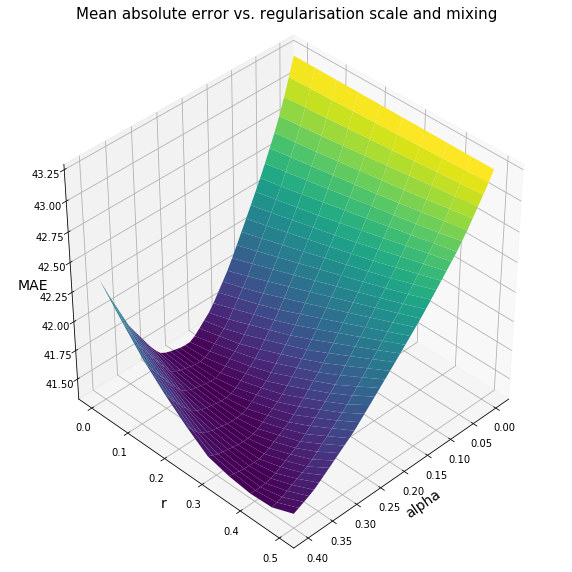

Optimal hyperparameters: alpha =  0.24 , r =  0.0


In [264]:
def fit_error(X_train, X_val, y_train, y_val, alpha, r):
    model = MyLinearRegression()
    model.fit(X_train, y_train, solver='numerical', alpha=alpha, r=r, num_iterations=200)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

alpha_list = np.linspace(0,0.4,40)
r_list = np.linspace(0,0.5,10)

mean_abs_error = np.zeros((len(alpha_list),len(r_list)))
for i, a in enumerate(alpha_list):
    for j, r in enumerate(r_list):
        mean_abs_error[i][j] = fit_error(X_train, X_val, y_train, y_val, alpha=a, r=r)

A, R = np.meshgrid(alpha_list, r_list)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
# ax.contour3D(A, R, mean_abs_error.T, 80 ,cmap='viridis')
ax.plot_surface(A, R, mean_abs_error.T, rstride=1, cstride=1 ,cmap='viridis', edgecolor='None')
ax.view_init(40,45)
ax.set_xlabel('alpha', fontsize=14)
ax.set_ylabel('r', fontsize=14)
ax.set_zlabel('MAE', fontsize=14)
plt.title('Mean absolute error vs. regularisation scale and mixing', y=1.08, fontsize=15)
plt.show()

i, j = np.unravel_index(mean_abs_error.argmin(), mean_abs_error.shape)
optimal_alpha = alpha_list[i]
optimal_r = r_list[j]
print('Optimal hyperparameters: alpha = ',np.round(optimal_alpha, 2), ', r = ', np.round(optimal_r, 2))

Therefore we see that the MAE for the validation data is minimised for a regularised linear regression, in particular, pure Ridge regression (r=0). What MAE do these hyperparameters give?

In [228]:
opt_model = MyLinearRegression()
opt_model.fit(X_train, y_train, solver='numerical', alpha=0.24, r=0.0)
opt_y_pred = opt_model.predict(X_val)
mae = mean_absolute_error(y_val, my_y_pred)
print('Best mean absolute error: ', np.round(mae, 2))

Best mean absolute error:  41.36


This is the best MAE yet, exceeding the performance of both mine and sklearn's analytical solution for non-reularised Linear Regression.

Next let's have a look at how the gradient descent algorithm causes the model to converge to the optimal solution.

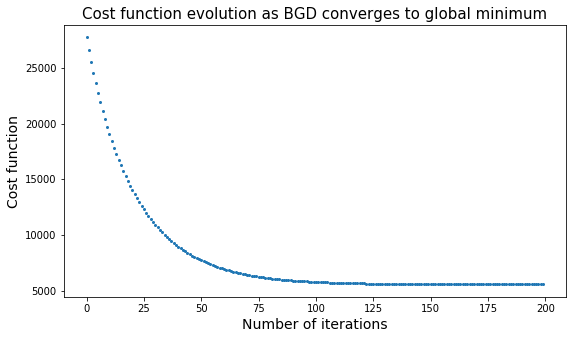

In [242]:
plt.figure(figsize=(9,5))
plt.scatter(range(len(opt_model.cost_vec)), opt_model.cost_vec, s=4)
plt.title('Cost function evolution as BGD converges to global minimum',fontsize=15)
plt.xlabel('Number of iterations',fontsize=14)
plt.ylabel('Cost function',fontsize=14);

We can look at how the Linear Model's $\theta$ parameters at each iteration reflect this convergence.

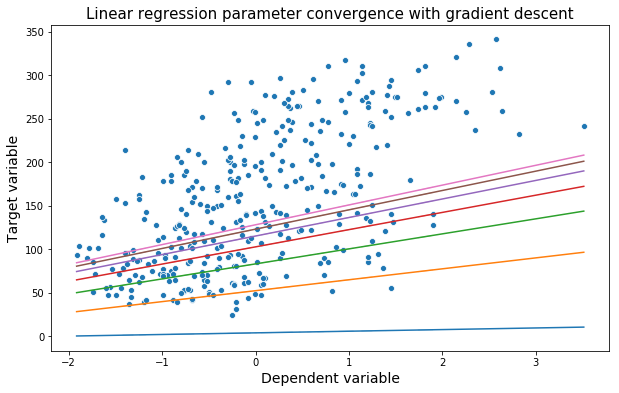

In [269]:
# Prepare the data to fit the converging model parameters to
X_data = MyLinearRegression.pre_process_data(X_train)

# The addition of 1 to feature number is due to the column of ones inserted during preprocessing. This plots y
# as a function of one of the dependent variables during successive stages in the iterative convergence using 
# the model weights at each stage.
plt.figure(figsize=(10,6))
feature_num = 2
sns.scatterplot(X_data[:, feature_num+1], y_train)
temp_theta = opt_model.theta_iterations
for iteration_num in range(0, 140, 20):
    theta_0, theta_N = temp_theta[[0, feature_num+1], iteration_num]
    sns.lineplot(X_data[:, feature_num+1], theta_0 + theta_N * X_data[:, feature_num+1])
plt.xlabel('Dependent variable', fontsize=14)
plt.ylabel('Target variable', fontsize=14)
plt.title('Linear regression parameter convergence with gradient descent', fontsize=15);

That concludes this notebook on regularised Linear resgression from scratch, thanks for reading.